
# Lecture 4 — Ordinary Differential Equations (ODEs)

## Learning outcomes

- Recognize when ODE **integrators** are needed and the assumptions behind (Initial Value Problems) IVPs.
- Derive the **Forward Euler** method from a Taylor Series Expansion (TSE).
- Understand the idea of **Runge–Kutta** (RK) methods (RK45).
- Implement a simple **Euler integrator** and compare against analytical solutions.
- Use `scipy.integrate.solve_ivp` and its useful functionalities (events, forcing functions).



## 1) Motivation in chemical engineering

A few examples:

- **Kinetics:** batch reactor decay/growth rates $dC/dt = r(C,t)$.


- **Bioprocesses:** cell growth (logistic/Monod), substrate consumption.


- **Reactors:** CSTR components and energy balances, residence time effects.


- **Control:** dynamic response to set point/step changes.

- **Transport Phenomena**: Mass/Heat/Momentum transfer can be modeled using ODE systems.



We typically know an **initial condition** $y(t_0)=y_0$ and a **differential equation (or equations)** $y'(t)=f(t,y)$; 


we seek $y(t)$ for $t\in[t_0,t_f]$.



## 2) Derivation — Forward Euler from TSE

Start with the initial value problem (IVP)


$$
\frac{dy}{dt} = y'(t) = f(t,y), \quad y(t_0)=y_0
$$

The **Taylor expansion** of $y(t)$ at $t_n$ is


$$
y(t_{n+1}) = y(t_n) + h\,y'(t_n) + \text{higher order terms}
$$

in which $h=t_{n+1} - t_{n}$ and since $y'(t_n) = f(t,y)$, we have

$$
y(t_{n+1}) = y_n + h\,f(t_n,y_n) + \text{higher order terms}
$$

Dropping higher-order terms gives the **Euler update formula**

$$
y_{n+1} = y_n + h\,f(t_n, y_n),
$$


## 3) Runge–Kutta (RK) idea (overview)

Goal: improve accuracy by sampling $f$ within the step. This is achieved by doing the algebra above, but keeping high order terms from TSE.

**Classical RK4 (fixed step)** uses four stages


$$
\begin{aligned}
k_1 &= f(t_n, y_n),\\
k_2 &= f\!\big(t_n + \tfrac{h}{2},\, y_n + \tfrac{h}{2}k_1\big),\\
k_3 &= f\!\big(t_n + \tfrac{h}{2},\, y_n + \tfrac{h}{2}k_2\big),\\
k_4 &= f\!\big(t_n + h,\, y_n + h\,k_3\big),
\end{aligned}
$$


and the update


$$
y_{n+1} = y_n + \tfrac{h}{6}\,(k_1 + 2k_2 + 2k_3 + k_4).
$$

The idea is similar to Euler's (which is also known as... $1^{st}$ order Runge-Kutta method), it just uses higher order terms in the TSE. The math is a bit tedious but if you are interested you can take a look online.

**Adaptive RK45 (Dormand–Prince)** (used in `solve_ivp(method='RK45')`) estimates the local error by embedding a 4th- and 5th-order pair and **automatically adjusts $h$** to meet tolerances (`rtol`, `atol`).



## 4) A minimal Euler integrator (fixed step)


How the code looks like for the simplest integrator (Euler / $1^{st}$ order RK)? Here's an example!

In [1]:
import numpy as np


def euler(f, t_span, y0, h):

    """
    A very simple Euler integrator (a.k.a 1st order Runge-Kutta)



    Inputs
    -------
    f: function
        The function that represents the RHS f(t, y).
    t_span: (t0, tf) tuple
        Integration interval
    y0: float
        Initial condition at t0.
    h: float
        Fixed step size
    
    Returns
    -------

    t: np.ndarray
        Time points
    Y: np.ndarray
        Solution values at each time.
    
    
    """

    t0, tf  = float(t_span[0]), float(t_span[1])

    t = np.append(np.arange(t0, tf, h), tf)


    Y = np.empty((t.size, ))


    Y[0] = y0 


    for i in range(t.size - 1):

        Y[i + 1] = Y[i] + h * (f(t[i], Y[i]))

    return t, Y 


## 5) Example 1 — Batch reactor first-order decay

Let's look at first-order kinetics in a batch reactor. This example has an analytical solution. Hence, we will be able to check the accuracy of our integrator :)


The model is conceptually simple, defined as 

$$\,\dfrac{dC}{dt} = -kC,\ \ C(0)=C_0$$

The analytical solution is given as $$\,C(t)=C_0 e^{-kt}.$$ 

Let's compare Euler to the exact solution and to `scipy.integrate.solve_ivp` at the default method (RK45).


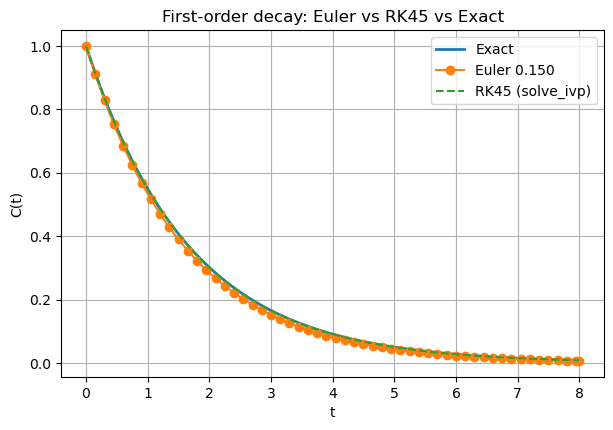

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Constants
C0, k = 1.0, 0.6

# Our ODE
def batch_reactor(t, C):
    return -k * C

# Euler call
step = 0.15
t_eu, C_eu = euler(batch_reactor, (0.0, 8.0), C0, h=step)

# Exact solution over a range
t_exact = np.linspace(0, 8, 200)
C_exact = C0*np.exp(-k*t_exact)

# RK45
sol = solve_ivp(batch_reactor, (0.0, 8.0), [C0], method='RK45', rtol=1e-8, atol=1e-10, dense_output=True)
t_rk = np.linspace(0, 8, 200)
C_rk = sol.sol(t_rk)[0]

plt.figure(figsize=(7,4.5))
plt.plot(t_exact, C_exact, label='Exact', lw=2)
plt.plot(t_eu, C_eu, 'o-', label=f'Euler {step:.3f}')
plt.plot(t_rk, C_rk, '--', label='RK45 (solve_ivp)')
plt.xlabel('t')
plt.ylabel('C(t)')
plt.title('First-order decay: Euler vs RK45 vs Exact')
plt.grid(True); plt.legend(); plt.show()


If we reduce the step size $h$, Euler's method gets closer to both the analytical solution and RK45.


## 6) Example 2 — Events (stop when some desired threshold/condition is reached)

Let's assume that a generic bioprocess is modeled after the following ODE:


$$
\frac{dX}{dt} = r\,X\left(1 - \frac{X}{K}\right), \quad X(0)=X_0.
$$

$r, K$ are constants specific to the biomass that is increasing, $X$. We want to stop the integration when $X(t)$ hits $0.9K$ (an **event**). 

In `solve_ivp`, we achieve this by setting the keyword argument `event.terminal = True` and `event.direction = +1` (rising).


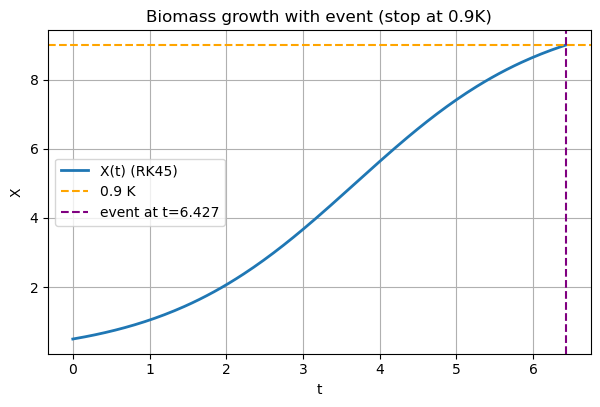

In [3]:
# Our constants and initial condition
r, K, X0 = 0.8, 10.0, 0.5

def bioprocess(t, X):
    dXdt = r * X * (1.0 - X / K)
    return dXdt

def hit_90pct(t, X):
    # event when X - 0.9K = 0 (crossing upward)
    return np.array(X) - 0.9*np.array(K)

hit_90pct.terminal = True
hit_90pct.direction = +1.0


sol = solve_ivp(bioprocess, 
                (0.0, 20.0), 
                [X0], 
                events=hit_90pct, 
                rtol=1e-8, 
                atol=1e-10, 
                dense_output=True)


t_plot = np.linspace(0, sol.t_events[0][0], 200) if len(sol.t_events[0])>0 else np.linspace(0, 20, 200)
X_plot = sol.sol(t_plot)[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4.2))
plt.plot(t_plot, X_plot, lw=2, label='X(t) (RK45)')


if len(sol.t_events[0])>0:
    t_hit = sol.t_events[0][0]
    plt.axhline(0.9*K, color='orange', ls='--', label='0.9 K')
    plt.axvline(t_hit, color='purple', ls='--', label=f'event at t={t_hit:.3f}')
plt.xlabel('t'); plt.ylabel('X')
plt.title('Biomass growth with event (stop at 0.9K)')
plt.grid(True); plt.legend(); plt.show()





## 7) Example 3 — Forcing function (CSTR concentration step change)

One more example. In this CSTR, we can manipulate its inlet concentration $C_{in}$. This is not uncommon in process control, for example. The system is modeled as:


$$
\frac{dC}{dt} = \frac{F}{V}\,\big(C_{\text{in}}(t) - C\big) - k\,C,
\quad C(0)=C_0.
$$


Let $C_{\text{in}}(t)=1$ for $t<5$ and $C_{\text{in}}(t)=2$ for $t\ge 5$.


In [2]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

F, V, k = 1.0, 2.0, 0.3
C0 = 0.5
t_span = [0.0, 20.0]


def C_in(t):
    # This makes the concentration change when t >= 5
    return 1.0 if t < 5.0 else 2.0

def cstr(t, C):
    # Simple CSTR balance

    dCdt = (F/V)*(C_in(t) - C) - k*C
    return dCdt

# Let's solve this with dense_output=True so we can plot the solution easily
sol = solve_ivp(cstr, t_span, [C0], dense_output=True)

print(sol)




  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.380e-01 ...  1.942e+01  2.000e+01]
        y: [[ 5.000e-01  5.131e-01 ...  1.250e+00  1.250e+00]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x10791f8c0>
 t_events: None
 y_events: None
     nfev: 98
     njev: 0
      nlu: 0


Let's see if this is working!

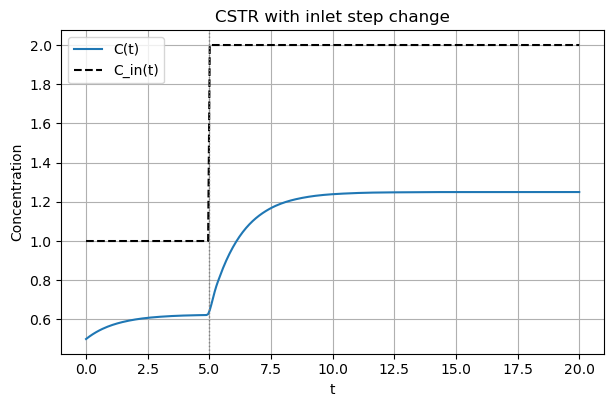

In [3]:
t_grid = np.linspace(0, 20, 300)
C = sol.sol(t_grid)[0]
Cin = np.array([C_in(ti) for ti in t_grid])
plt.figure(figsize=(7,4.2))
plt.plot(t_grid, C, label='C(t)')
plt.plot(t_grid, Cin, 'k--', label='C_in(t)')
plt.axvline(5.0, color='grey', ls=':', lw=1)
plt.xlabel('t'); plt.ylabel('Concentration')
plt.title('CSTR with inlet step change')
plt.grid(True); plt.legend(); plt.show()

ha ha!


## 8) Practice problems you might get asked in your HW...

- Derive Euler from TSE; implement and test on a known solution; study step-size effects.
- Use `solve_ivp` with `events` to detect and stop at thresholds (e.g., safety limits in a chemical reactor).
- Model a forced system (e.g., CSTR) with time-dependent inputs.
- Explore `method='RK45'` (adaptive) and `method='BDF'` (for stiff problems).
